# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [51]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
# %conda install wget

In [53]:
# !wget -O data.txt.zip https: // archive.ics.uci.edu / ml / machine-learning-databases / 00203 / YearPredictionMSD.txt.zip

In [54]:
df = pd.read_csv('data.txt.zip', header=None)
df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].min()) / (df.iloc[:, 1:].max() - df.iloc[:, 1:].min())

df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,0.800293,0.497205,0.599629,0.332545,0.370583,0.276962,0.452564,0.302498,0.492380,...,0.352499,0.490087,0.372344,0.644339,0.569286,0.460524,0.613453,0.334855,0.500338,0.362200
1,2001,0.780177,0.492987,0.595220,0.341113,0.386532,0.229635,0.546232,0.359274,0.532466,...,0.346752,0.494001,0.367177,0.650031,0.550999,0.459186,0.613745,0.354687,0.506122,0.385477
2,2001,0.817124,0.511606,0.571964,0.342073,0.394968,0.254988,0.512831,0.352096,0.522585,...,0.344695,0.499157,0.350453,0.643421,0.567316,0.470228,0.587814,0.337376,0.504859,0.359438
3,2001,0.772129,0.464800,0.540674,0.319971,0.411973,0.224074,0.535929,0.311991,0.476686,...,0.369357,0.476865,0.357216,0.631499,0.546663,0.475993,0.593813,0.351622,0.515629,0.377862
4,2001,0.817341,0.525963,0.590047,0.331972,0.374082,0.261984,0.487309,0.316833,0.509999,...,0.350082,0.489912,0.373525,0.637490,0.564964,0.462806,0.611127,0.348736,0.505936,0.387203


In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [6]:
print('Nulls:', df.isna().sum().sum())

Nulls: 0


In [7]:
df.dtypes

0       int64
1     float64
2     float64
3     float64
4     float64
       ...   
86    float64
87    float64
88    float64
89    float64
90    float64
Length: 91, dtype: object

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

Наилучший константный прогноз для MSE (как и для RMSE) - это среднее таргета

In [9]:
const_year = np.mean(np.concatenate([y_test, y_train]))
const_rmse = mean_squared_error(y_test, np.full((y_test.shape[0], 1), const_year, dtype=float), squared=False)
print('Const year:', const_year, 'RMSE:', const_rmse)

Const year: 1998.3970815667174 RMSE: 10.8523584464736


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [10]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [11]:
y_train

array([2001, 2001, 2001, ..., 2007, 2006, 2007], dtype=int64)

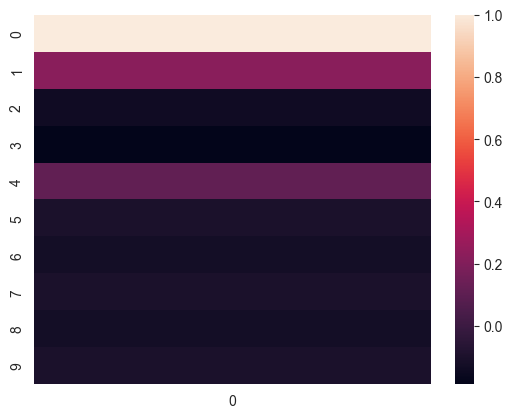

6    -0.187443
3    -0.139541
63   -0.126348
40   -0.123974
67   -0.102841
        ...   
20    0.087057
47    0.096088
7     0.110460
1     0.225374
0     1.000000
Name: 0, Length: 91, dtype: float64

In [12]:
corr = df.corr()[0]
sns.heatmap(corr[abs(corr) > 0.1].values.reshape(-1, 1))
plt.show()
corr.sort_values()

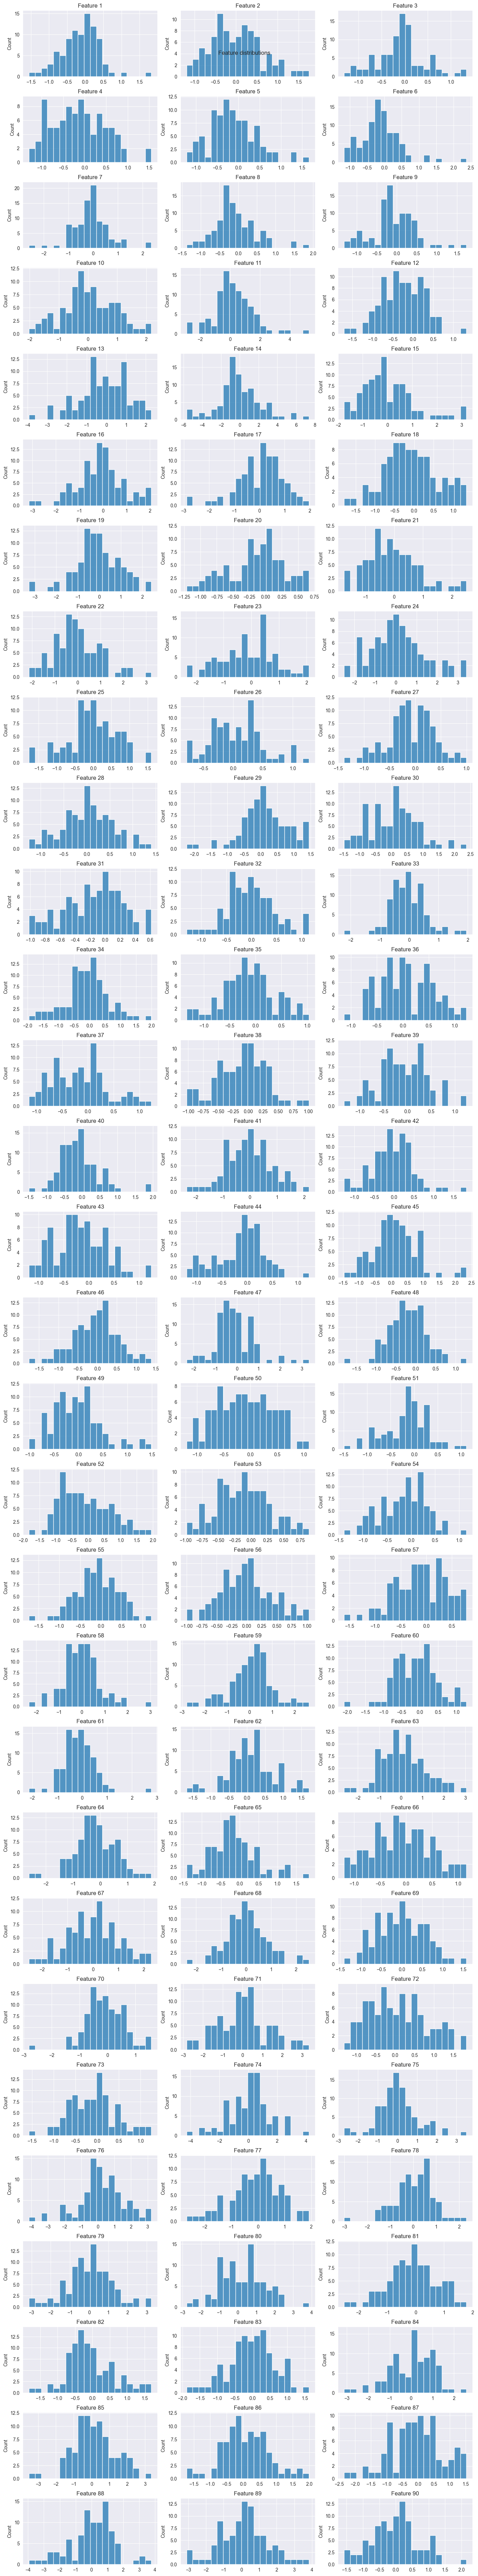

In [50]:
fig, axes = plt.subplots(30, 3, figsize=(14, 75))
fig.tight_layout(pad=2.0)
print('Feature distributions')

for feat in range(X_train.shape[1]):
    ax = axes[feat // 3][feat % 3]
    sns.histplot(X_train[feat], ax=ax, bins=20)
    ax.set_title(f"Feature {feat + 1}")

plt.show()

Вывод: нет сильной корреляции признаков с таргетом

Число признаков весьма обильно, сильной корреляции нет. Посмотрели на распределения признаков, увидели много нормальных

Нормируем признаки. y_test намеренно не трогаем

In [13]:
from sklearn.preprocessing import StandardScaler

std_scaler_target = StandardScaler()
std_scaler_features = StandardScaler()

X_train = std_scaler_features.fit_transform(X_train)
X_test = std_scaler_features.transform(X_test)

y_train = std_scaler_target.fit_transform(y_train.reshape(-1, 1))

Реализуем датасет для нашей задачи

In [14]:
from torch.utils.data import Dataset


class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.copy()
        self.y = y.copy()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx, :], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

Хотел использовать раннюю остановку, но передумал

In [15]:
# Взял отсюда крутой класс https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """

    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


Архитектура модели

In [16]:
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

set_random_seed(723)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 256
train_set = AudioDataset(X=X_train, y=y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = AudioDataset(X=X_test, y=y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0012, weight_decay=0.003)
scheduler = StepLR(optimizer, step_size=4, gamma=0.75)

criterion = torch.nn.MSELoss()
# early_stopping = EarlyStopping(patience=5, min_delta=0.002)

Функции для логгирования результатов модели и построения графика

In [17]:
import os


def save_config(model, optimizer, stat, batch_size, scheduler, path='models_info.csv'):
    model_conf = '\n'.join(map(str, model)) + f'\n{str(optimizer)}' + f'\n{batch_size}' + f'\n{str(scheduler)}'
    dict_model = {
        'id': [stat['id']],
        'model_conf': [model_conf],
        **{f'{i}_train': [v] for i, v in enumerate(stat['train'], 1)},
        **{f'{i}_test': [v] for i, v in enumerate(stat['test'], 1)},
    }

    df = pd.DataFrame(dict_model)
    df.to_csv(path, mode='a', header=not os.path.exists(path), index=False)


def plotter(ep, stats):
    plt.figure(figsize=(14, 8))
    plt.plot(list(range(1, ep + 1)), stats['train'], label='train')
    plt.plot(list(range(1, ep + 1)), stats['test'], label='test')
    plt.ylabel("Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.title("Train\\Test loss by epoch", fontsize=18)
    plt.legend()
    if ep % 10 == 0:
        plt.savefig(f'{stats["id"]}.png')
    plt.show()

In [18]:
from IPython.core.display_functions import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt


def train(model, optimizer, criterion, train_loader, test_loader, scheduler, stopper, epochs=100):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    stats = {
        'train': [],
        'test': [],
        'id': (hash(model) + hash(scheduler) + hash(optimizer)) * hash(batch_size + 1) ^ 104729
    }

    for ep in range(1, epochs + 1):
        train_loss_unscaled = 0

        for X_train_batch, y_train_batch in tqdm(train_loader):
            X_train_batch = X_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)

            optimizer.zero_grad()
            y_train_pred = model(X_train_batch)

            y_train_pred_unscaled = torch.Tensor(std_scaler_target.inverse_transform(y_train_pred.cpu().data)).to(
                device)
            y_train_batch_unscaled = torch.Tensor(std_scaler_target.inverse_transform(y_train_batch.cpu().data)).to(
                device)

            train_loss_unscaled += criterion(y_train_pred_unscaled, y_train_batch_unscaled)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_loss.backward()
            optimizer.step()

        if scheduler.get_last_lr()[0] > 0.0001:
            scheduler.step()
        y_pred = test(model, test_loader)

        test_loss_unscaled = torch.sqrt(criterion(y_pred, torch.Tensor(test_loader.dataset.y).to(device))).data

        stats['train'].append(float(torch.sqrt(train_loss_unscaled / len(train_loader)).item()))
        stats['test'].append(float(test_loss_unscaled))

        if ep > 3:
            clear_output(True)

        plotter(ep, stats)

        print(
            f'Epoch {ep}: Train Loss: {stats["train"][-1]}. Test Loss: {stats["test"][-1]}')
        print('LR:', scheduler.get_last_lr())
        for name, param in model.named_parameters():
            print(name, 'norm:', torch.norm(param).data)

        if ep == 10:
            save_config(model, optimizer, stats, scheduler, batch_size)

        if stopper:
            stopper(stats["test"][-1])
            if stopper.early_stop:
                break


def test(model, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = torch.ones(len(test_loader.dataset)).to(device)
    offset = 0

    with torch.no_grad():
        for X_test_batch, y_test_batch in tqdm(test_loader):
            X_test_batch = X_test_batch.to(device)
            y_pred = model(X_test_batch)
            y_test_pred_unscaled = torch.Tensor(std_scaler_target.inverse_transform(y_pred.cpu().data)).to(device)

            predicts[offset:offset + 256] *= y_test_pred_unscaled[:, 0]
            offset += 256

    return predicts

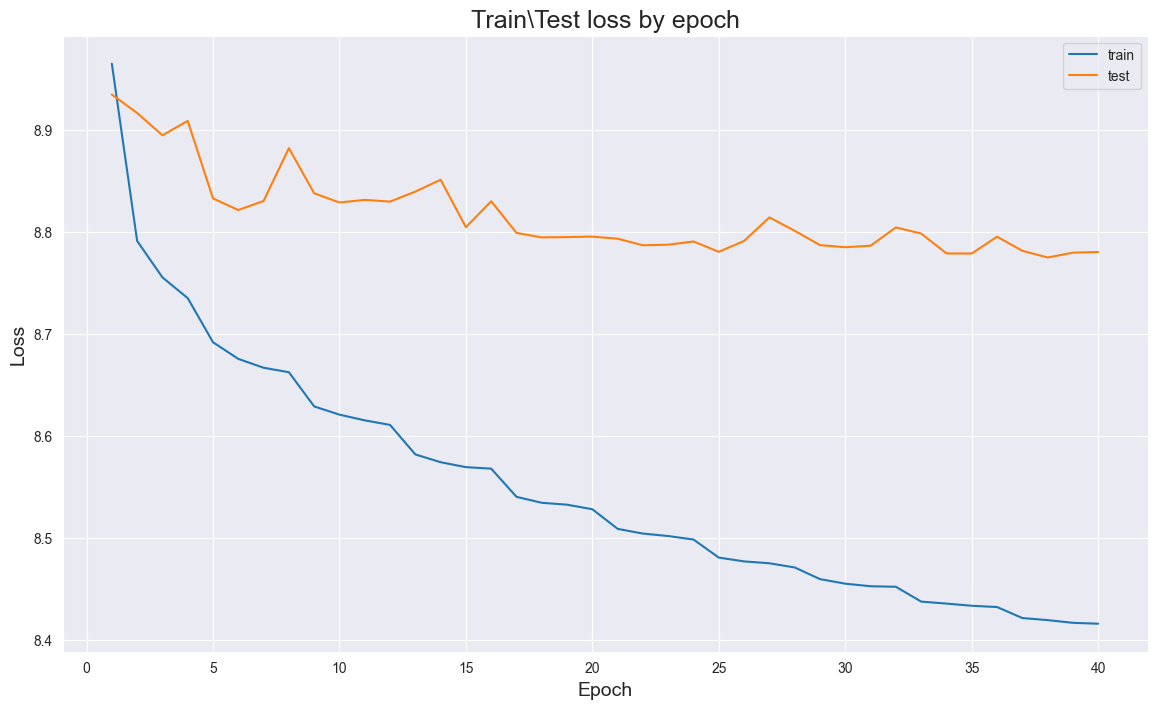

Epoch 40: Train Loss: 8.415597915649414. Test Loss: 8.780200004577637
LR: [9.010162353515624e-05]
0.weight norm: tensor(2.9602, device='cuda:0')
0.bias norm: tensor(0.7592, device='cuda:0')
2.weight norm: tensor(2.4824, device='cuda:0')
2.bias norm: tensor(0.6107, device='cuda:0')
4.weight norm: tensor(2.4451, device='cuda:0')
4.bias norm: tensor(0.0871, device='cuda:0')


In [19]:
train(model, optimizer, criterion, train_loader, test_loader, scheduler, None, epochs=40)

In [21]:
assert test(model, test_loader).shape[0] == y_test.shape[0]

100%|██████████| 202/202 [00:01<00:00, 168.47it/s]


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Начнем с начала. Первой идеей было построить просто линейную модель с SGD (чтобы понять, что вообще есть в PyTorch). Однако, один линейный слой давал качество сильно хуже, нежели Ridge.
После этого я применил MinMaxScaler к признакам и качество стало +- сопоставимым.
Далее, я добавил еще 3 слоя с примерно 256 признаками. Начался жесткий танец ошибки туда-сюда, который я пытался пофиксить weight_decay (а потом и dropout'ами), думая что это оверфит.
Тут пришла идея убрать оставить 3 слоя и понизить ширину (192 - 128), что лишь отчасти помогло. Потом я стал рисовать графики лосса от эпохи и логгировать (файл models_info.csv) первые 10 эпох модели, дабы не потерять их конфигурацию.
В какой-то момент я таки нормализовал таргет StandardScaler. Ошибка все еще скачет. Но наконец я меняю MinMaxScaler для признаков на StandardScaler и о чудо ошибка почти не пляшет.
Решая проблему дикого танца ошибки, я попробовал оптимизатор Adam, что очень сильно помогло. Трейн стал +- хорошо обучаться на 30-40 эпохах, поэтому в итоге я и выбрал это число.
Но в какой-то момент модель сильно недообучалась. Я стал добавлять шедулер, уменьшающий lr с эпохой.
Трейн стал очень круто обучаться, начался оверфиттинг, который я лечил сначала опять dropout'ами, что у меня не получилось, а потом weight_decay.
Перебирая долгое время lr, step_size, gamma и weight_decay, (ширину в 128 каждого слоя и глубину в 3 слоя я зафиксировал довольно давно, так как казалось, что она весьма сбалансированна) я пришел к данному качеству.
Позже, в процессе осознования жизни и перебора всего чего только можно, с нормально настроенным шедулером и регуляризацией я получал 0.74...: примерно так, но на ранней эпохе

In [22]:
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

set_random_seed(723)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 256
train_set = AudioDataset(X=X_train, y=y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = AudioDataset(X=X_test, y=y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(90, 192),
    nn.ReLU(),
    nn.Linear(192, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0015, weight_decay=0.00075)
scheduler = StepLR(optimizer, step_size=2, gamma=0.25)

criterion = torch.nn.MSELoss()

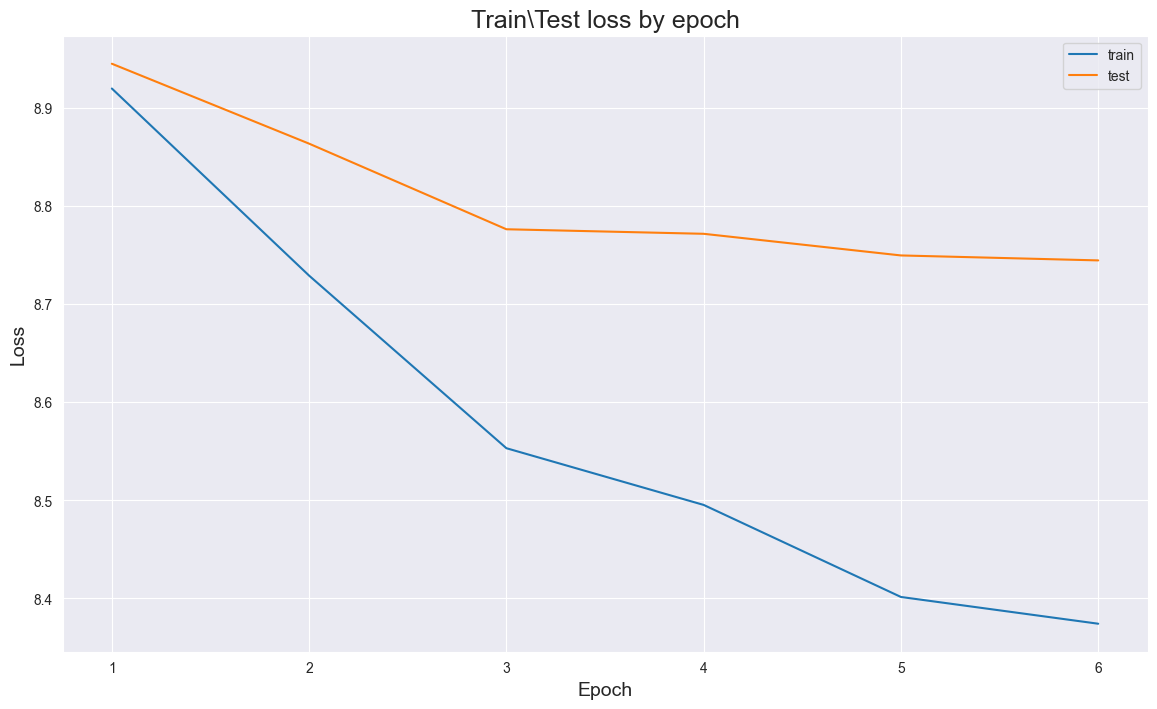

Epoch 6: Train Loss: 8.37427043914795. Test Loss: 8.744746208190918
LR: [9.375e-05]
0.weight norm: tensor(6.3389, device='cuda:0')
0.bias norm: tensor(1.5317, device='cuda:0')
2.weight norm: tensor(3.9834, device='cuda:0')
2.bias norm: tensor(1.3145, device='cuda:0')
4.weight norm: tensor(1.4962, device='cuda:0')
4.bias norm: tensor(0.0753, device='cuda:0')


In [23]:
train(model, optimizer, criterion, train_loader, test_loader, scheduler, None, epochs=6)
